<a href="https://colab.research.google.com/github/stepanjaburek/quantum_social_science_lr/blob/main/Factor_Cluster_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install factor_analyzer scikit-learn-extra plotly
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.8 MB/s eta 0:00:00
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42623 sha256=6db2e59b9ea6f55f74f09420a081d3f2f5325d5c3661577df9f0684f4e8b1875
  Stored in directory: /root/.cache/pip/wheels/fa/f7/53/a55a8a56668a6fe0199e0e02b6e0ae3007ec35cdf6e4c25df7
Successfully built factor_analyzer


In [7]:
from google.colab import drive
drive.mount('/content/drive') # this asks for your google account
# load data from our private google folder shared among us
df = pd.read_excel("/content/drive/MyDrive/QSS_Colab/keyword_data.xlsx")
metadata = pd.read_excel("/content/drive/MyDrive/QSS_Colab/metadata.xlsx")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Filter rows with at least one non-zero value and remove filename column
features = df[df.iloc[:, 1:22].sum(axis=1) > 0].drop(columns=['filename'])

# Log transformation + constant (we have zeros in the data)
features = features.apply(lambda x: np.log(x + 0.1))

KMO Test Overall: 0.727
Bartlett's test: chi² = 3778.629, p = 0.0000000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


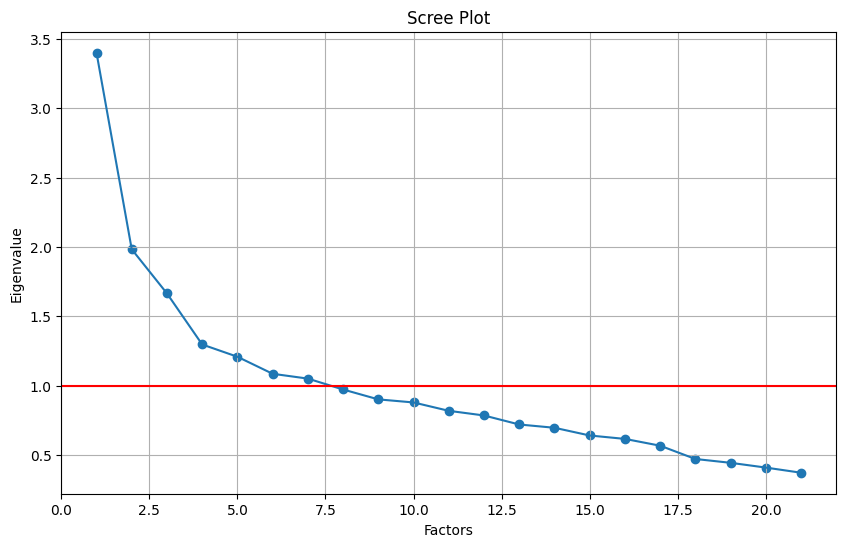

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Factor Loadings (cutoff = 0.3):
                       Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  Factor 7
born's rule                 NaN       NaN       NaN       NaN       NaN       NaN       NaN
collapse               0.614720       NaN       NaN       NaN       NaN       NaN       NaN
commutativity               NaN       NaN       NaN       NaN       NaN       NaN  0.503752
complementarity             NaN       NaN       NaN       NaN       NaN       NaN  0.445980
contextuality               NaN       NaN       NaN       NaN       NaN       NaN  0.335291
eigenvalue                  NaN  0.822786       NaN       NaN       NaN       NaN       NaN
eigenvector                 NaN  0.722057       NaN       NaN       NaN       NaN       NaN
entanglement           0.386269       NaN       NaN       NaN       NaN       NaN       NaN
exclusion principle         NaN       NaN       NaN       NaN       NaN       NaN       NaN
hamiltonian                 NaN       NaN  0.52

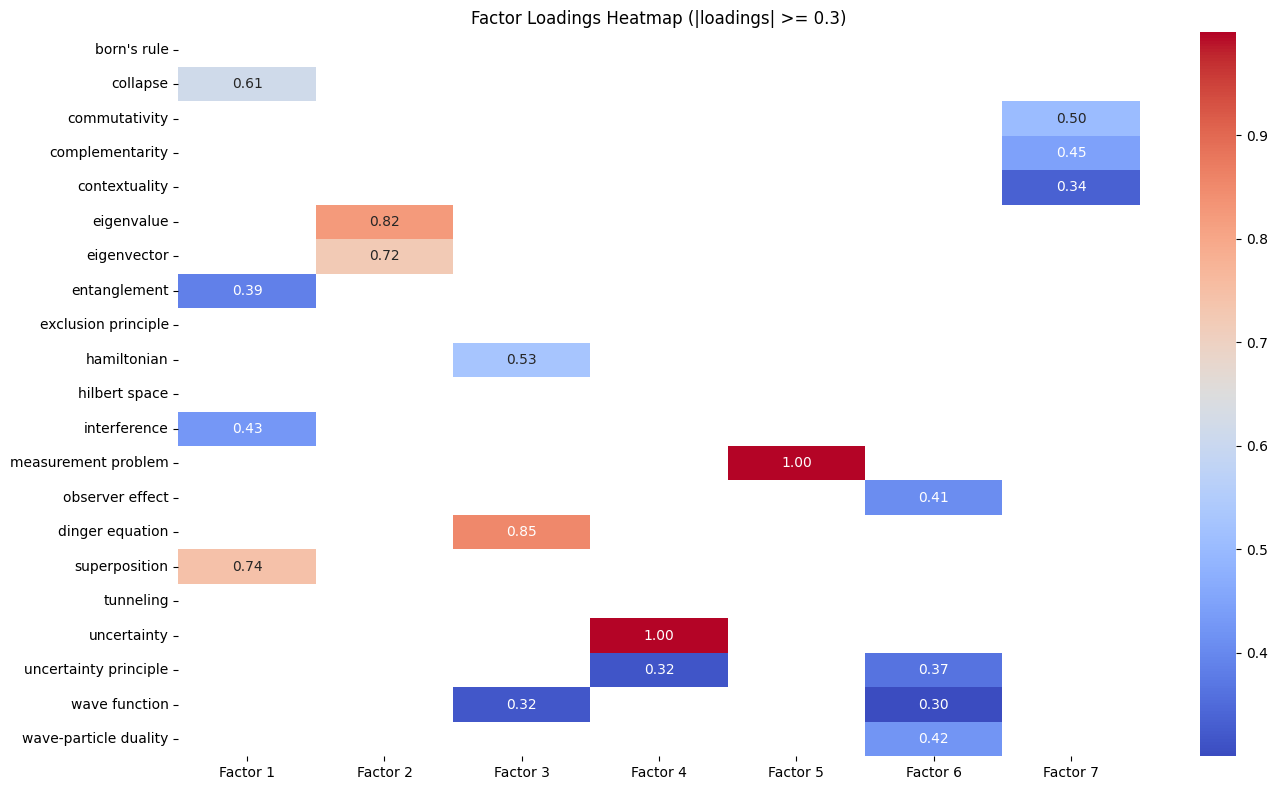

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [9]:
# ##############################
# Exploratory Factor Analysis
# ###################
# Check if the data is suitable for factor analysis
# KMO test (Kaiser-Meyer-Olkin)
kmo_all, kmo_model = calculate_kmo(features)
print(f"KMO Test Overall: {kmo_model:.3f}")  # Should be > 0.5

# Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(features)
print(f"Bartlett's test: chi² = {chi_square_value:.3f}, p = {p_value:.10f}")  # p-value should be < 0.05

# Determine number of factors to extract - Parallel Analysis
# In Python, we'll use scree plot and explained variance as an alternative
fa = FactorAnalyzer(rotation=None)
fa.fit(features)
ev, v = fa.get_eigenvalues()

# Plot scree plot
plt.figure(figsize=(10, 6))
plt.scatter(range(1, len(ev)+1), ev)
plt.plot(range(1, len(ev)+1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.axhline(y=1, color='r', linestyle='-')  # Kaiser criterion: eigenvalue > 1
plt.show()

# Based on the scree plot and your R code, we'll extract 7 factors
# EFA with Maximum Likelihood and Oblimin rotation
n_factors = 7
fa = FactorAnalyzer(n_factors=n_factors, rotation='oblimin', method='ml')
fa.fit(features)

# Print factor loadings
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, index=features.columns,
                           columns=[f'Factor {i+1}' for i in range(n_factors)])
print("\nFactor Loadings (cutoff = 0.3):")
print(loadings_df.where(abs(loadings_df) >= 0.3).to_string())

# Variance explained
variance = fa.get_factor_variance()
variance_df = pd.DataFrame(variance,
                          index=['SS Loadings', 'Proportion Var', 'Cumulative Var'],
                          columns=[f'Factor {i+1}' for i in range(n_factors)])
print("\nVariance Explained:")
print(variance_df)

# Visualize factor loadings with heatmap
plt.figure(figsize=(14, 8))
mask = abs(loadings_df) < 0.3  # Mask values below 0.3 for clarity
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', mask=mask, fmt='.2f')
plt.title('Factor Loadings Heatmap (|loadings| >= 0.3)')
plt.tight_layout()
plt.show()

# Get factor scores for clustering
factor_scores = fa.transform(features)
factor_scores_df = pd.DataFrame(factor_scores,
                               columns=[f'Factor {i+1}' for i in range(n_factors)])

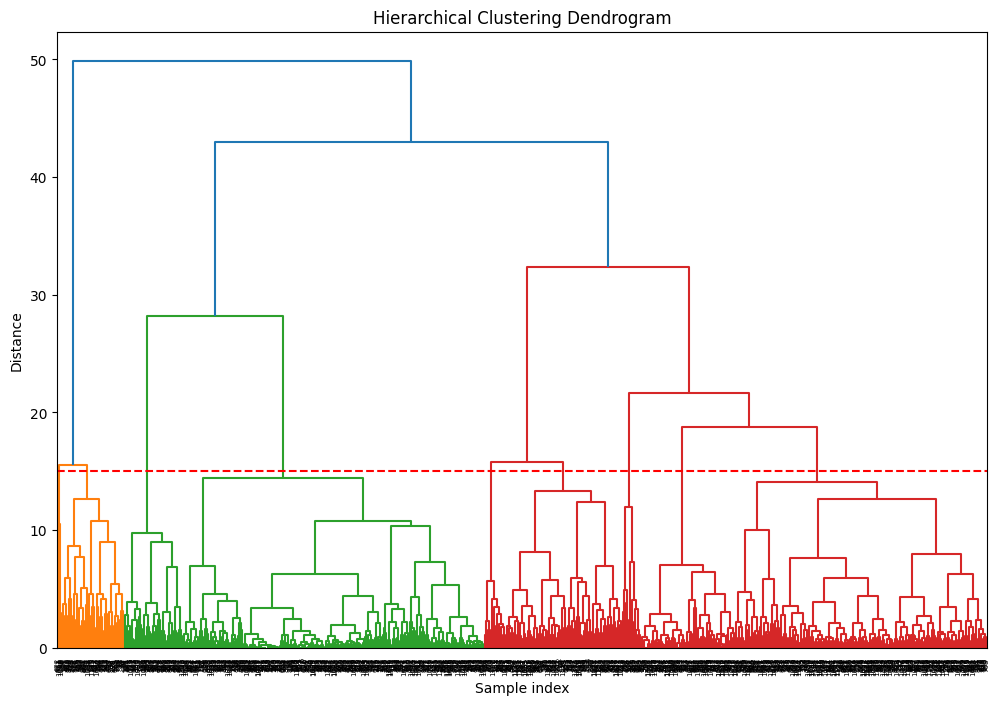

For n_clusters = 2, the silhouette score is 0.330
For n_clusters = 3, the silhouette score is 0.250
For n_clusters = 4, the silhouette score is 0.261
For n_clusters = 5, the silhouette score is 0.275
For n_clusters = 6, the silhouette score is 0.249
For n_clusters = 7, the silhouette score is 0.255
For n_clusters = 8, the silhouette score is 0.251
For n_clusters = 9, the silhouette score is 0.246


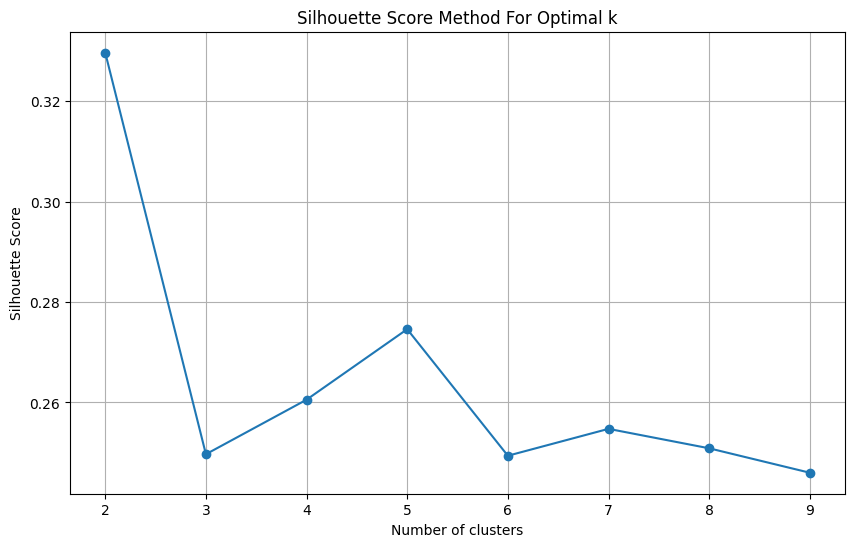

In [10]:
# #########################
# Hierarchical Clustering on Factor Scores
# ################
# Compute linkage matrix for hierarchical clustering
Z = linkage(factor_scores, method='ward')

# Plot dendrogram to identify optimal number of clusters
plt.figure(figsize=(12, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(Z)
plt.axhline(y=15, color='r', linestyle='--')  # Example cutoff, adjust based on your data
plt.show()

# Determine optimal number of clusters using silhouette score
silhouette_scores = []
range_n_clusters = range(2, 10)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=25)
    cluster_labels = clusterer.fit_predict(factor_scores)
    silhouette_avg = silhouette_score(factor_scores, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method For Optimal k')
plt.grid(True)
plt.show()

In [11]:
n_clusters = 4  # Adjust based on your analysis

# #######################
# K-means on factor scores
# ################
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=25)
kmeans_labels = kmeans.fit_predict(factor_scores)

# Visualize K-means clusters with plotly (similar to fviz_cluster)
# We'll use PCA to reduce to 2D for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
factor_scores_2d = pca.fit_transform(factor_scores)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'PC1': factor_scores_2d[:, 0],
    'PC2': factor_scores_2d[:, 1],
    'Cluster': kmeans_labels
})

# Plot with plotly
fig = px.scatter(plot_df, x='PC1', y='PC2', color='Cluster',
                title='K-means clustering on EFA factor scores',
                color_continuous_scale=px.colors.qualitative.Set1)

# Add cluster centroids
centroids_2d = pca.transform(kmeans.cluster_centers_)
fig.add_trace(go.Scatter(
    x=centroids_2d[:, 0], y=centroids_2d[:, 1],
    mode='markers',
    marker=dict(symbol='x', size=15, color='black'),
    name='Centroids'
))

fig.show()


Cluster profiles (mean factor scores):
         Factor 1  Factor 2  Factor 3  Factor 4  Factor 5  Factor 6  Factor 7
Cluster                                                                      
0        0.475512  1.714821  0.477215  0.421490  0.171708 -0.197704  0.654331
1        0.356019 -0.375481  0.329585  0.095710  0.368158  0.695773 -0.336217
2        0.114372 -0.325905 -0.284329  0.814887 -0.204937 -0.323465  0.320741
3       -0.627226 -0.330092 -0.243830 -1.041283 -0.183053 -0.126441 -0.386433


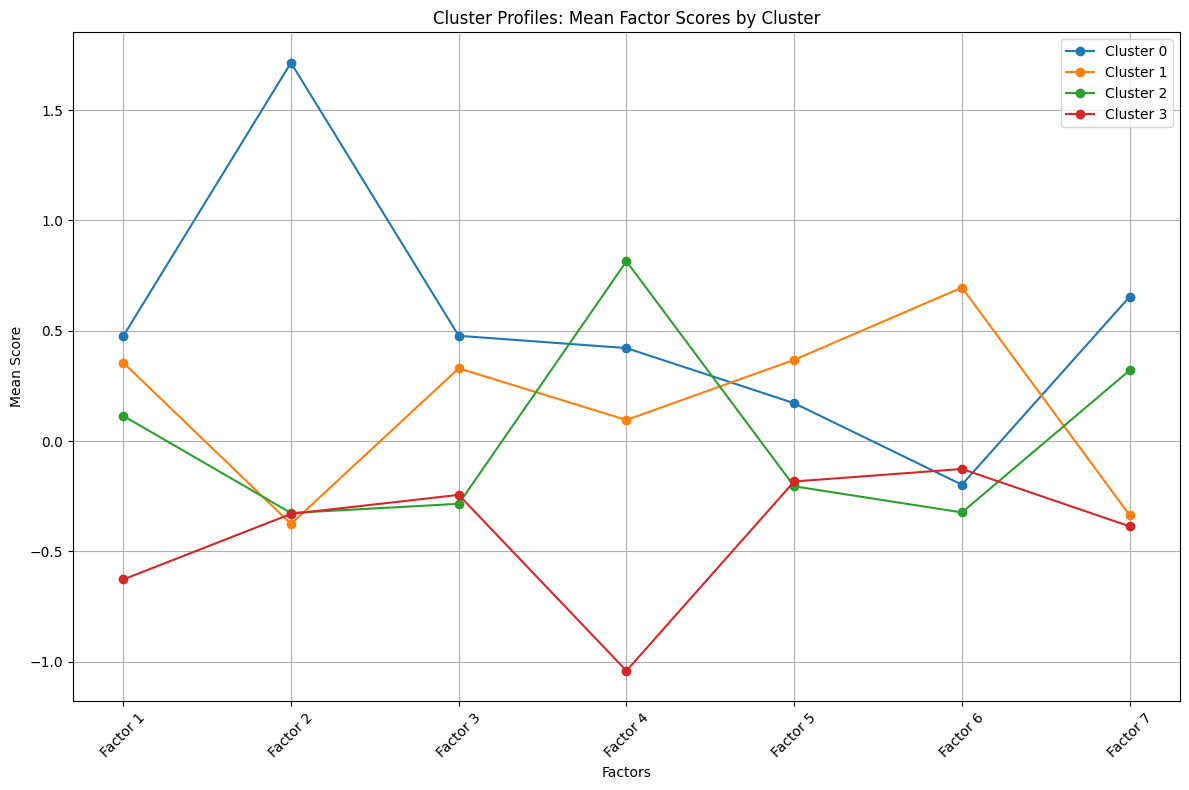

In [13]:
# ##############################
# K-Medoids (PAM) on factor scores
# ################
kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
pam_labels = kmedoids.fit_predict(factor_scores)

# Visualize PAM clusters with plotly
plot_df['PAM_Cluster'] = pam_labels
fig = px.scatter(plot_df, x='PC1', y='PC2', color='PAM_Cluster',
                title='Factor Analysis with PAM Clustering',
                color_continuous_scale=px.colors.qualitative.Set1)

# Add medoid positions
medoids_2d = pca.transform(factor_scores[kmedoids.medoid_indices_])
fig.add_trace(go.Scatter(
    x=medoids_2d[:, 0], y=medoids_2d[:, 1],
    mode='markers',
    marker=dict(symbol='x', size=15, color='black'),
    name='Medoids'
))

fig.show()

# Cluster profiles - mean factor scores by cluster
cluster_profiles = pd.DataFrame(factor_scores, columns=[f'Factor {i+1}' for i in range(n_factors)])
cluster_profiles['Cluster'] = pam_labels
profile_means = cluster_profiles.groupby('Cluster').mean()
print("\nCluster profiles (mean factor scores):")
print(profile_means)

# Visualize the cluster profiles
plt.figure(figsize=(12, 8))
for i in range(n_clusters):
    plt.plot(profile_means.columns, profile_means.iloc[i], marker='o', label=f'Cluster {i}')
plt.title('Cluster Profiles: Mean Factor Scores by Cluster')
plt.xlabel('Factors')
plt.ylabel('Mean Score')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Add the cluster labels back to the original data
df_with_clusters = df.copy()
# First, align indices with factor_scores
valid_indices = df[df.iloc[:, 1:22].sum(axis=1) > 0].index
df_with_clusters.loc[valid_indices, 'PAM_Cluster'] = pam_labels
df_with_clusters.loc[valid_indices, 'KMeans_Cluster'] = kmeans_labels

# Export clustered data
df_with_clusters.to_excel("clustered_data.xlsx", index=False)
profile_means.to_excel("cluster_profiles.xlsx")

#print("Analysis complete! Exported files with cluster assignments and profiles